# [Project 6] Classification of Traffic Sign Images

---

## Project Goals
- Perform a classification model that analyzes traffic sign image data and predicts the type of sign through a deep learning model
- Learning the process of pre-processing a large amount of image data and the performance change of the CNN model accordingly

---

## Project Table of Contents
1. **Data analysis:** Analysis and confirmation of elements constituting image data using Dataframe<br>
     1-1. Understanding image data information - Meta<br>
     1-2. Understanding image data information - Train<br>
     1-3. Understanding image data information - Test<br>


2. **Data preprocessing:** Read the image data and preprocess it as input to the deep learning model<br>
     2-1. Reading image data<br>
     2-2. Read label data<br>
     2-3. Separating data<br>


3. **Deep Learning Models:** Implement CNN models and perform training, evaluation and prediction<br>
     3-1. CNN model setup<br>
     3-2. Doing Learning<br>
     3-3. Evaluate and predict model performance<br>

---

## Data source
-  https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

---

## Project outline

Seeing road traffic signs and obeying the rules while driving a vehicle is important for you and your traffic safety. If a machine, not a human, had to do this, how would it be able to tell the signs apart? This question has become an important issue with the development of autonomous vehicle technology, and a classification model based on deep learning technology is being applied with a considerable level of accuracy.

In this project, as the first step of classifying traffic signs, we implement a deep learning model that classifies which of 43 types of signs when a traffic sign image is simply input. Through this, it is possible to learn to perform classification through the characteristics of traffic sign image data and the CNN model.

Extending the first step, in the future, we will use an object detection model that separates and classifies traffic signs from road images instead of using images with only traffic signs as input. You can perform a model to isolate and classify .

<img src="img/1-1.jpg" width="100%" height="100%" title="개요" alt="개요"></img>

- Object etection 이미지 참조 논문: V.N. Sichkar, S.A. Kolyubin, "Real time detection and classification of traffic signs based on YOLO version 3 algorithm", Scientific and Technical Journal of Information Technologies Mechanics and Optics 20(3):418-424

---

In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential


%matplotlib inline

## 1. Data Analysis

### 1-1. Understanding image data information - Meta

이미지 데이터를 읽어오기 위해서 `./data` 에 어떠한 파일들이 존재 하는지 확인해 봅시다.

In [2]:
file_list = os.listdir('./data')
file_list

['Meta', 'Meta.csv', 'Test', 'Test.csv', 'Train', 'Train.csv']

3개의 폴더와 3개의 csv 파일이 있습니다. 일반적으로 이미지 데이터의 csv 파일이 제공되는 경우에는, 해당 이미지의 디렉토리 정보가 저장되어 있습니다.

그렇기에 먼저,csv 파일을 dataframe으로 읽어 보겠습니다.

In [3]:
import pandas as pd

df_Meta = pd.read_csv('./data/Meta.csv')
df_Meta

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/0.png,0,1,0,3.29
1,Meta/1.png,1,1,0,3.29
2,Meta/2.png,2,1,0,3.29


`Meta.csv`는 Meta 폴더 내의 이미지에 대한 정보를 담고 있습니다. 위정보를 바탕으로 이미지를 출력해봅시다.

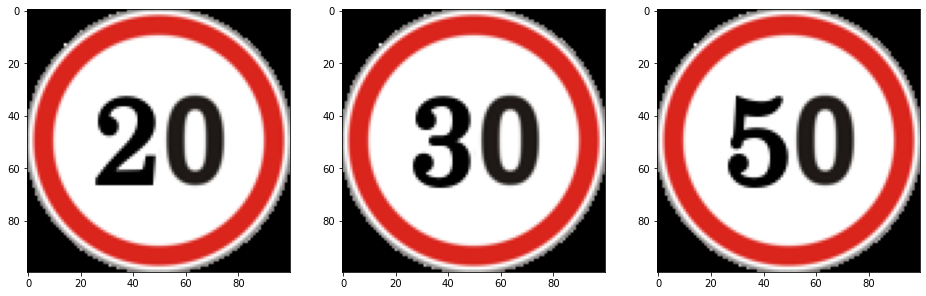

In [4]:
Meta_images = []
Meta_labels = []

plt.figure(figsize=(16,16))
for i in range(len(df_Meta)):
    img = load_img('./data/'+df_Meta['Path'][i])
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    Meta_images.append(img)
    Meta_labels.append(df_Meta['ClassId'][i])

### 1-2. Understanding image data information - Train

이번엔 `Train.csv`를 확인해 봅시다.

In [5]:
df_Train = pd.read_csv('./data/Train.csv')
df_Train

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,29,30,5,6,24,25,0,Train/0/00000_00000_00000.png
1,30,30,5,5,25,25,0,Train/0/00000_00000_00001.png
2,30,30,5,5,25,25,0,Train/0/00000_00000_00002.png
3,31,31,5,5,26,26,0,Train/0/00000_00000_00003.png
4,30,32,5,6,25,26,0,Train/0/00000_00000_00004.png
...,...,...,...,...,...,...,...,...
2665,50,51,6,6,45,46,2,Train/2/00002_00040_00025.png
2666,52,52,6,6,47,47,2,Train/2/00002_00040_00026.png
2667,55,55,6,6,50,50,2,Train/2/00002_00040_00027.png
2668,59,58,6,5,53,52,2,Train/2/00002_00040_00028.png


2670개의 학습용 이미지 데이터에 대한 정보가 저장되어 있음을 알 수 있습니다.

이러한 이미지 정보 중에 먼저 `Width`와 `Height`에 대해서 알아봅시다.

`Width`와 `Height` 정보는 이미지의 폭과 높이에 대한 정보로 간단히 샘플만 봐도 다양한 크기를 갖는 것을 알 수 있습니다.

이미지 크기가 모두 다르다면 이미지마다 서로 다른 feature의 개수가 있는 것이기에 이를 통일해주는 전 처리가 필요합니다.

그렇다면 어떤 크기로 통일을 해야 할까요? 이미지 크기의 분포를 보고 판단해봅시다.

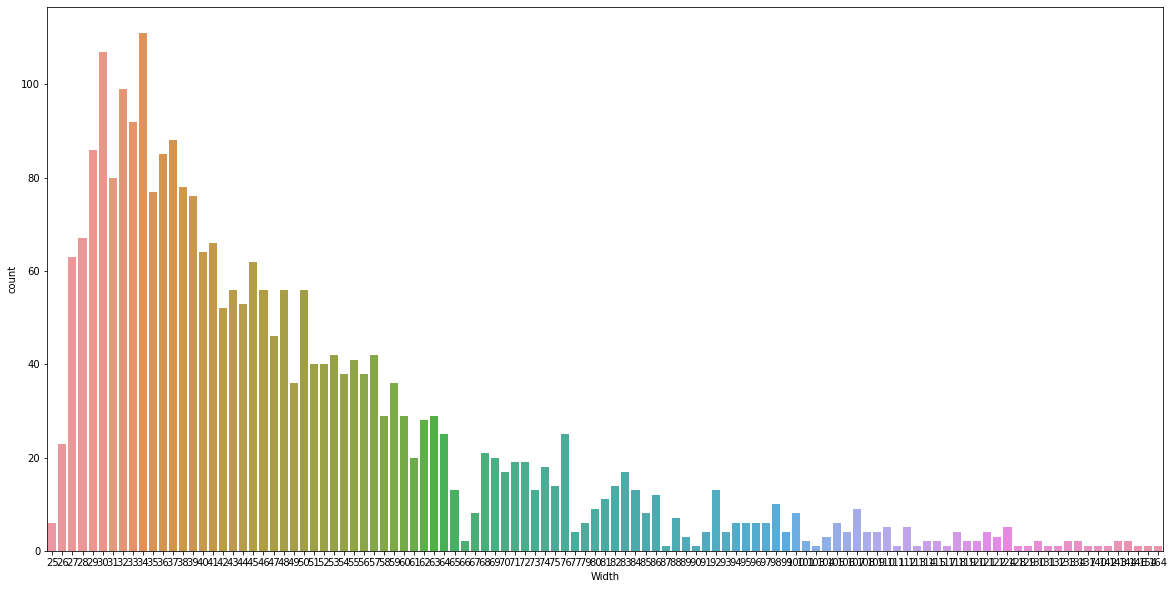

In [6]:
import seaborn as sns

plt.figure(figsize=(20,10))
ax = sns.countplot(x="Width", data=df_Train)

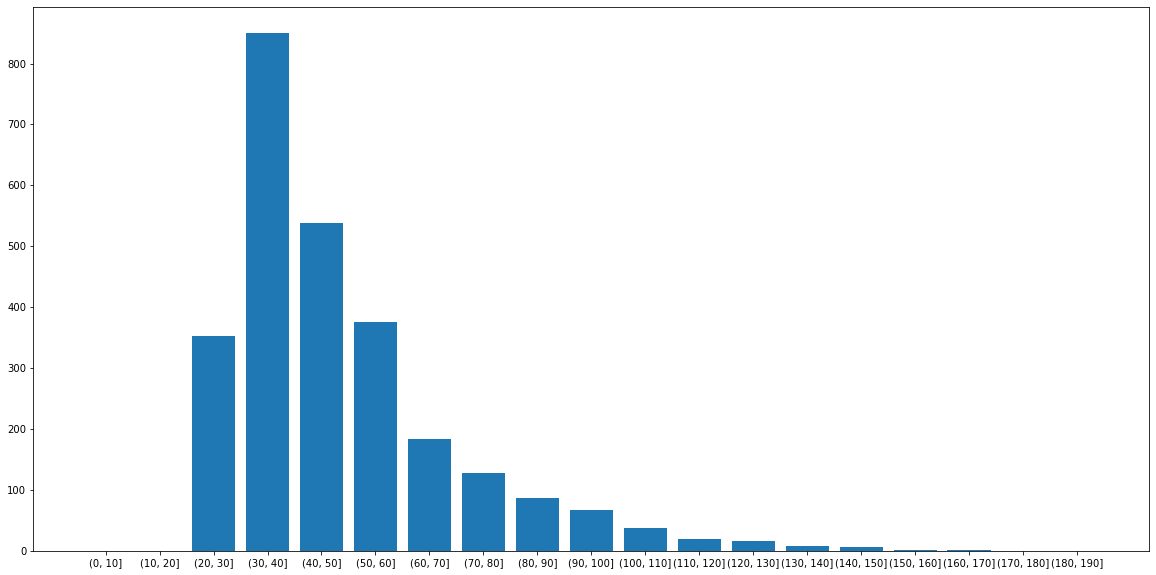

In [7]:
df_cutWidth = pd.cut(df_Train['Width'], np.arange(0,200,10)).value_counts(sort=False)

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(range(len(df_cutWidth)),df_cutWidth.values)
ax.set_xticks(range(len(df_cutWidth)))
ax.set_xticklabels(df_cutWidth.index)
fig.show()

위 분포를 보게 되면 30~35의 폭 또는 높이를 갖는 이미지가 제일 많음을 확인했습니다. 

이미지 크기를 통일하는 데 있어서 너무 작은 이미지는 큰 이미지의 정보 손실을 발생하며, 너무 큰 이미지는 작은 이미지의 정보 부족한 정보량을 부각할 것입니다. 

따라서 적절한 이미지 크기를 잡는 것은 하나의 파라미터 조정이 되며, 이번 프로젝트에서는 이미지 분포 기반으로 대다수를 차지하는 크기인 33x33 크기로 통일하겠습니다. (이후, 개인적인 실습에서 데이터 크기 조절에 따른 성능 변화를 살펴보는 것도 좋은 학습이 될 것입니다.)

In [8]:
image_height = 33
image_width = 33
image_channel = 3 # 컬러 이미지이기에 3채널

이번엔 Roi 데이터에 대해서 살펴봅시다. 이미지 데이터에서 Roi는 Region of interest의 약자로 지금 데이터에서는 표지판이 있는 부분을 의미합니다.

`Train.csv`, `Test.csv` 파일에 있는 Roi 데이터는 아래 실행된 이미지에서의 좌측 상단 좌표와 우측 하단 좌표를 의미합니다.

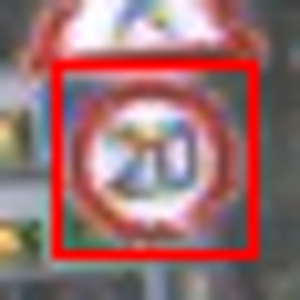

In [9]:
from PIL import Image
from PIL import ImageDraw

img_sample = Image.open('./data/'+df_Train['Path'][0])

draw = ImageDraw.Draw(img_sample)
draw.rectangle([df_Train['Roi.X1'][0], df_Train['Roi.Y1'][0], df_Train['Roi.X2'][0], df_Train['Roi.Y2'][0]], outline="red")
img_sample_resized = img_sample.resize((300,300))
img_sample_resized

Roi 데이터를 사용하면 보다 명확하게 표지판 부분만을 crop 할 수 있으며, 이러한 데이터 전 처리를 통하여 분류의 성능을 높일 수 있습니다. (이번 프로젝트에서는 해당 전 처리를 생략합니다.)

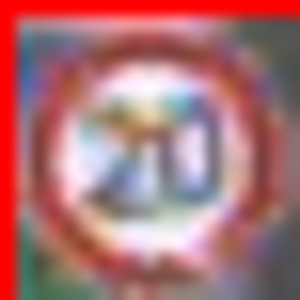

In [10]:
img_sample_crop = img_sample.crop((df_Train['Roi.X1'][0], df_Train['Roi.Y1'][0], df_Train['Roi.X2'][0], df_Train['Roi.Y2'][0]))
 
# Shows the image in image viewer
img_sample_crop_resized = img_sample_crop.resize((300,300))
img_sample_crop_resized

### 1-3. Understanding image data information - Test

이번엔 `Test.csv`를 살펴보겠습니다.

In [11]:
df_Test = pd.read_csv('./data/Test.csv')
df_Test

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,42,45,5,5,36,40,1,Test/00001.png
1,59,65,5,6,54,60,1,Test/00024.png
2,58,59,6,6,53,54,2,Test/00034.png
3,37,37,5,6,31,32,2,Test/00067.png
4,45,51,6,6,40,46,1,Test/00076.png
...,...,...,...,...,...,...,...,...
695,34,33,5,5,28,28,1,Test/05537.png
696,58,56,6,6,52,50,1,Test/05539.png
697,37,38,5,5,32,33,1,Test/05551.png
698,28,30,5,6,23,25,2,Test/05579.png


Train.csv와 같은 형태로 구성되어 있는 것을 알 수 있습니다. test 데이터에 대해서는 분석하는 것은 표지판을 분류 하는 목적에 있어 큰 의미가 있지 않기에 이번 실습에서는 생략합니다.

**퀴즈1. Roi 영역에 크기에 맞게 `df_Test['Path'][0]` 해당되는 이미지에 crop을 수행한 후 (300, 300) 해상도로 resize 합니다.**

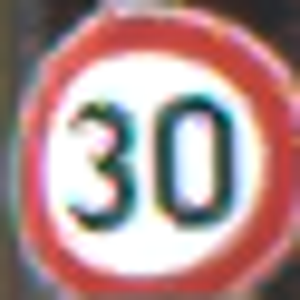

In [12]:
# crop함수를 활용하여 이미지를 잘라낼 수 있습니다.
# 이 후, resize함수를 활용하여 사이즈 변경을 수행합니다.

img_sample_test = Image.open('./data/'+df_Test['Path'][0])

img_sample_crop_test = img_sample_test.crop((df_Test['Roi.X1'][0], df_Test['Roi.Y1'][0], df_Test['Roi.X2'][0], df_Test['Roi.Y2'][0]))

img_sample_resized_test= img_sample_crop_test.resize((300,300))
img_sample_resized_test


In [13]:
# 결과 PIL 이미지 객체를 저장합니다. 
quiz_1 = img_sample_resized_test

## 2. Data Preprocessing

### 2-1. Reading image data

통일된 이미지 크기를 바탕으로 이미지를 읽어 보겠습니다.

먼저 학습용 이미지를 불러와 `Train_images`에 array 형태로 저장합니다.

In [14]:
image_height = 33
image_width = 33
image_channel = 3

Train_images = []
Train_labels = []

for i in tqdm(range(len(df_Train))):
    img = load_img('./data/'+df_Train['Path'][i], target_size = (image_height, image_width))
    img = img_to_array(img)
    Train_images.append(img)

100%|██████████| 2670/2670 [01:04<00:00, 41.54it/s]


같은 방식으로 평가용 이미지를 불러와 `Test_images`에 array 형태로 저장합니다.

In [15]:
Test_images = []
Test_labels = []

for i in tqdm(range(len(df_Test))):
    img = load_img('./data/'+df_Test['Path'][i], target_size = (image_height, image_width))
    img = img_to_array(img)
    Test_images.append(img)

100%|██████████| 700/700 [00:16<00:00, 42.93it/s]


### 2-2. Read label data

학습용, 평가용 데이터에 대한 label은 csv 파일에 `ClassId` 열로 저장되어 있기에 이를 불러와 array로 저장합니다.

In [16]:
Train_labels = df_Train['ClassId'].values
Train_labels

array([0, 0, 0, ..., 2, 2, 2])

In [17]:
Test_labels = df_Test['ClassId'].values
Test_labels

array([1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2,
       1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 0,
       2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2,
       2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 0, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1,
       0, 2, 2, 2, 2, 1, 1, 2, 0, 0, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1,
       1, 1, 1, 2, 1, 1, 2, 1, 2, 0, 1, 1, 2, 1, 0, 1, 2, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 0, 2, 1,
       2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 1, 1, 0, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2,
       1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 1, 1, 2, 2, 2,
       1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 0, 2, 1, 1, 2, 2, 1, 2,
       1, 1, 2, 2, 2, 2, 1, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2,

### 2-3. Separating data 

딥러닝 학습 시, 과적합을 막기 위하여 validation 데이터를 학습용 데이터에서 분리합니다. 

모든 데이터는 numpy array로 저장합니다.

In [18]:
x_train, x_val, y_train, y_val = train_test_split(np.array(Train_images), np.array(Train_labels), test_size=0.4)

평가용 데이터도 적용합니다.

In [19]:
x_test = np.array(Test_images)
y_test = np.array(Test_labels)

## 3. Deep Learning Models

### 3-1. CNN model setup

CNN을 사용하여 간단하게 모델을 구현해 보겠습니다. filters, kernel 등의 사이즈는 하이퍼 파리미터로 자신만의 모델로 튜닝이 가능합니다.

In [20]:
model = Sequential([    
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(image_height, image_width, image_channel)),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(rate=0.25),
    
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(rate=0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(rate=0.25),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 31, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

### 3-2. Conduct learning

3개의 class를 갖는 데이터이기에 loss 함수로 `sparse_categorical_crossentropy`을 설정하고 optimizer로는 adam을 사용하여 학습하여 보겠습니다.

In [21]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [22]:
# 처음 만든 모델이라면 EPOCHS를 1~5개로 하여 잘 돌아가는지 성능을 확인해보고 값을 증가 시켜 봅시다. 
EPOCHS = 30

# EPOCHS에 따른 성능을 보기 위하여 history 사용
history = model.fit(x_train, 
                    y_train,
                    validation_data = (x_val, y_val), # validation 데이터 사용
                    epochs=EPOCHS, 
                   )

Epoch 1/30
51/51 [==============================] - 2s 40ms/step - loss: 61.4015 - accuracy: 0.4284 - val_loss: 1.0841 - val_accuracy: 0.4691
Epoch 2/30
51/51 [==============================] - 2s 32ms/step - loss: 1.0681 - accuracy: 0.4943 - val_loss: 1.0043 - val_accuracy: 0.4766
Epoch 3/30
51/51 [==============================] - 2s 32ms/step - loss: 0.9472 - accuracy: 0.5172 - val_loss: 0.9641 - val_accuracy: 0.4738
Epoch 4/30
51/51 [==============================] - 2s 32ms/step - loss: 0.9524 - accuracy: 0.4936 - val_loss: 0.9172 - val_accuracy: 0.5066
Epoch 5/30
51/51 [==============================] - 2s 32ms/step - loss: 0.9443 - accuracy: 0.5128 - val_loss: 0.9227 - val_accuracy: 0.4738
Epoch 6/30
51/51 [==============================] - 2s 32ms/step - loss: 0.9008 - accuracy: 0.5230 - val_loss: 0.9032 - val_accuracy: 0.4944
Epoch 7/30
51/51 [==============================] - 2s 32ms/step - loss: 0.9003 - accuracy: 0.5366 - val_loss: 0.9034 - val_accuracy: 0.4925
Epoch 8/30
5

학습을 수행하면서 Accuracy와 Loss의 변화를 그래프로 출력하면 다음과 같습니다.

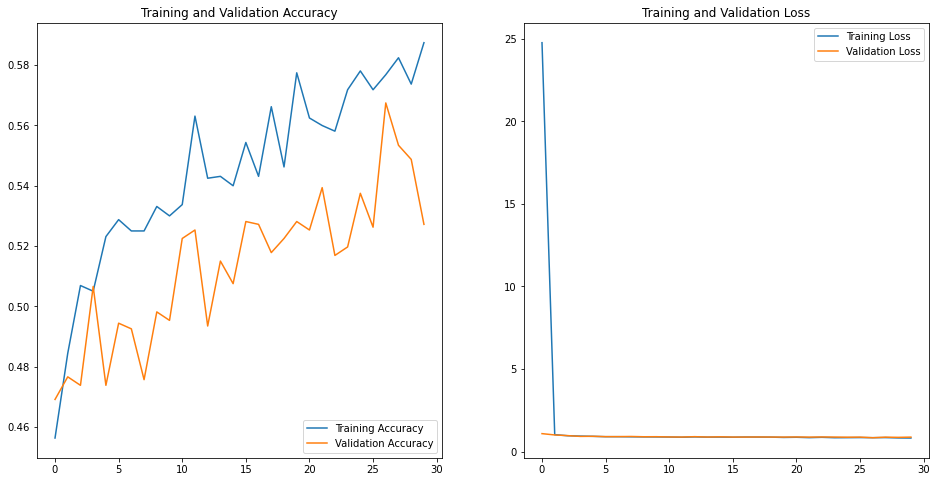

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 3-3. Evaluate and predict model performance

학습이 잘 수행 되었으면 평가용 데이터에서 성능이 잘 나오는 확인합니다.

In [24]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

print('test set accuracy: ', test_accuracy)

test set accuracy:  0.47857141494750977


이번엔 테스트 데이터를 입력하여 예측된 결과를 비교해 보겠습니다.

25개의 테스트 데이터를 불러와 실제 class와 예측 class를 출력하면 다음과 같습니다.

In [25]:
test_prediction = np.argmax(model.predict(x_test), axis=-1)

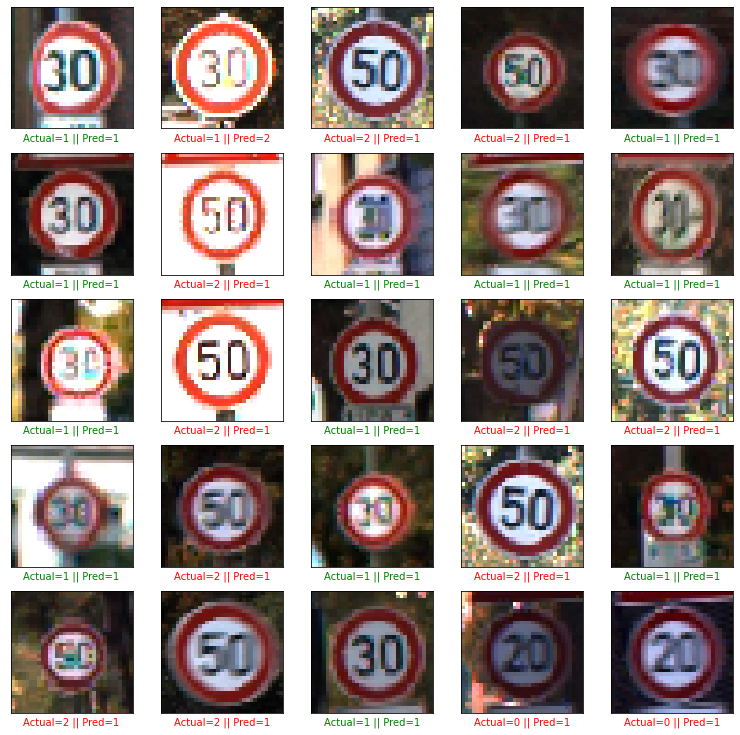

In [26]:
plt.figure(figsize = (13, 13))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = test_prediction[start_index + i]
    actual = y_test[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(array_to_img(x_test[start_index + i]))
plt.show()

마지막으로 confusion matrix를 시각화 하여 분류 학습 결과를 확인해봅니다.

<AxesSubplot:>

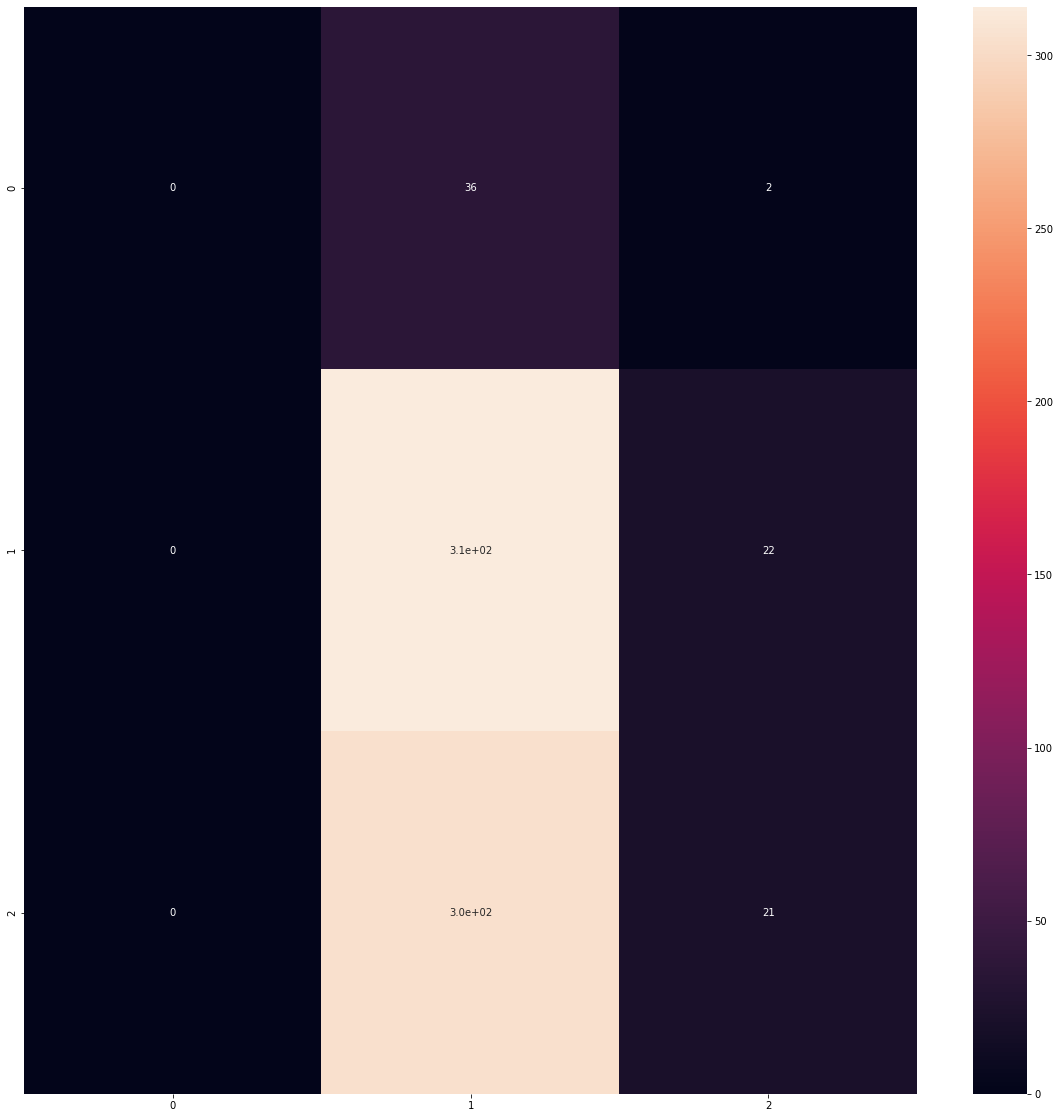

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, test_prediction)
plt.figure(figsize = (20, 20))
sns.heatmap(cm, annot = True)

**퀴즈2. 위 학습한 CNN 모델에서 학습용 데이터(`x_train, y_train`)의 confusion matrix를 구하세요.**

In [28]:
# CNN 모델의 x_train에 대한 예측값을 구하고 confusion_matrix() 를 사용하면 confusion matrix를 구할 수 있습니다.

train_prediction = np.argmax(model.predict(x_train), axis=-1)
cm_train = confusion_matrix(y_train, train_prediction)

In [29]:
# confusion_matrix() 결과값을 저장합니다. 
quiz_2 = cm_train

---

## Feedback

In this project, training was performed on only 3 labels, but the original data consists of 43 labels. In order to increase the accuracy as the number of labels increases, a crop image can be used in the pre-processing step or a method that increases the number of relatively small image data through data augmentation can be used. In the deep learning model, please try to increase the performance by using VGG, GoogLeNet, ResNet, etc., which have been proven to some extent in performance other than the above custom CNN model.

---